In [13]:
import gym
import copy
import torch
import random
import warnings
import itertools
import numpy as np
import pandas as pd
import torch.nn as nn
from torch import optim
from typing import Sequence
import matplotlib.pyplot as plt
import torch.nn.functional as F
from itertools import count, chain
from torch.distributions import Normal
from collections import namedtuple, deque

warnings.filterwarnings("ignore")

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# Soft Actor Critic (SAC)

In [14]:
#Define Actor Network
class PolicyNet(nn.Module):

    def __init__(self, input_size, hidden_units, output_size, pmin, pmax):
        super(PolicyNet, self).__init__()
        self.pmin = pmin
        self.pmax = pmax
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_units, device=device),
            nn.ReLU(),
            nn.Linear(hidden_units, int(hidden_units/2), device=device),
            nn.Tanh()
        )
        self.mu_head = nn.Linear(int(hidden_units/2),  output_size, device=device)
        self.logstd_head = nn.Linear(int(hidden_units/2),  output_size, device=device)

    def forward(self, x):
        x.to(device)
        x = self.model(x)
        loc = torch.tanh(self.mu_head(x)) * self.pmax
        scale = torch.exp(self.logstd_head(x))

        dist = Normal(loc, scale)
        action = dist.rsample()
        log_prob = dist.log_prob(action)
        log_prob = log_prob.sum(dim=-1, keepdim=True)
        log_prob -= (2* (np.log(2) - action - F.softplus(-2*action))).sum(dim=-1, keepdim=True)

        action = torch.tanh(action) * self.pmax

        return action, log_prob

#Define Critic Network
class DQN(nn.Module):

    def __init__(self, input_size, hidden_units):
        super(DQN, self).__init__()
        self.Q = nn.Sequential(
            nn.Linear(input_size, hidden_units, device=device),
            nn.ReLU(),
            nn.Linear(hidden_units, int(hidden_units/2), device=device),
            nn.ReLU(),
            nn.Linear(int(hidden_units/2), 1, device=device)
        )

    def forward(self, state, action):
        x = torch.cat([state, action], 1).to(device)
        q = self.Q(x)
        return q
    
    def __call__(self, state, action):
        out = self.forward(state, action)
        return out


#Define Replay Memory
Transition = namedtuple('Transition', ('states', 'actions', 'rewards', 'dones', 'next_states'))

class Replay_memory():

    def __init__(self, env, fullsize, minsize, batchsize):
        self.env = env
        self.memory = deque(maxlen=fullsize)
        self.rewards = deque(maxlen=50)
        self.batchsize = batchsize
        self.minsize = minsize

    def append(self, transition):
        self.memory.append(transition)
    
    def sample_batch(self):
        batch = random.sample(self.memory, self.batchsize)
        batch = Transition(*zip(*batch))
        states = torch.from_numpy(np.array(batch.states, dtype=np.float32)).to(device)
        actions = torch.from_numpy(np.array(batch.actions, dtype=np.float32)).to(device)
        rewards = torch.from_numpy(np.array(batch.rewards, dtype=np.float32)).unsqueeze(1).to(device)
        dones = torch.from_numpy(np.array(batch.dones, dtype=np.bool8)).unsqueeze(1).to(device)
        next_states = torch.from_numpy(np.array(batch.next_states, dtype=np.float32)).to(device)
        
        return states, actions, rewards, dones, next_states

    def initialize(self):
        obs = env.reset()
        for _ in range(self.minsize):
            action = self.env.action_space.sample()
            new_obs, reward, done, info = env.step(action)
            transition = Transition(obs, action, reward, done, new_obs)
            self.append(transition)
            obs = new_obs
            if done:
                self.env.reset()
        return self

def epsilon_greedy_policy(epsilon, policynet, obs):
    if random.random() > epsilon:
        action, _ = policynet(T(obs))
        action = action.cpu().numpy()
    else:
        action = env.action_space.sample()
    return action

#Define Constants
GAMMA = 0.99
BATCH_SIZE = 64
BUFFER_SIZE = 10000
MIN_REPLAY_SIZE = 5000
TAU = 0.05
POLICY_NOISE=0.2
NOISE_CLIP=0.5
EXPL_NOISE=0.1
POLICY_FREQ=2
EPSILON = 0.05
ALPHA = 0.02

#For Brevity
T  = lambda x: torch.as_tensor(x, dtype=torch.float32, device=device)
Ti = lambda x: torch.as_tensor(x, dtype=torch.int64, device=device)

In [15]:
env = gym.make(env_name := 'LunarLanderContinuous-v2')
obs_size = env.observation_space.shape[0]
act_size = env.action_space.shape[0]

output_minrange = T(env.action_space.low)
output_maxrange = T(env.action_space.high)

hiddenlayers = 256

#Replay Memory
replay_memory = Replay_memory(env, BUFFER_SIZE,
                              MIN_REPLAY_SIZE, BATCH_SIZE).initialize()


# Actor-Critic networks
q_net1 = DQN(obs_size + act_size, hiddenlayers)
q_net2 = DQN(obs_size + act_size, hiddenlayers)
actor = PolicyNet(obs_size, hiddenlayers, act_size, output_minrange, output_maxrange)

q_net1_target = copy.deepcopy(q_net1)
q_net2_target = copy.deepcopy(q_net2)
actor_target = copy.deepcopy(actor)

# Optimizers
q_net_params = itertools.chain(q_net1.parameters(), q_net2.parameters())
q_net_optimizer = optim.AdamW(q_net_params, lr=0.001)
policy_optimizer = optim.AdamW(actor.parameters(), lr=0.001)

In [16]:
def update(step):
    states, actions, rewards, dones, next_states = replay_memory.sample_batch()

    #Critic Loss
    action_values1 = q_net1(states, actions)
    action_values2 = q_net2(states, actions)

    with torch.no_grad():
        target_actions, target_log_probs = actor(next_states)

        next_action_values = torch.min(
            q_net1_target(next_states, target_actions),
            q_net2_target(next_states, target_actions)
        )
        next_action_values[dones] = 0.0
        target = rewards + GAMMA * (next_action_values - ALPHA * target_log_probs)

    Qloss1 = F.smooth_l1_loss(target, action_values1)
    Qloss2 = F.smooth_l1_loss(target, action_values2)
    Qloss_total = (Qloss1 + Qloss2)

    q_net_optimizer.zero_grad()
    Qloss_total.backward()
    q_net_optimizer.step()

    #Policy Loss
    actions, log_probs = actor(states)
    action_values = torch.min(
        q_net1(states, actions),
        q_net2(states, actions)
    )
    policy_loss = (ALPHA * log_probs - action_values).mean()

    policy_optimizer.zero_grad()
    policy_loss.backward()
    policy_optimizer.step()

    for target_param, param in zip(q_net1_target.parameters(), q_net1.parameters()):
        target_param.data.copy_(param.data * TAU + target_param.data * (1.0 - TAU))

    for target_param, param in zip(q_net2_target.parameters(), q_net2.parameters()):
        target_param.data.copy_(param.data * TAU + target_param.data * (1.0 - TAU))

    for target_param, param in zip(actor_target.parameters(), actor.parameters()):
        target_param.data.copy_(param.data * TAU + target_param.data * (1.0 - TAU))

## Training

In [17]:
returns = deque(maxlen=50)
history = []

for episode in count():
    state = env.reset()
    episode_reward = 0
    done = False
    while not done:
        with torch.no_grad():
            action = epsilon_greedy_policy(EPSILON, actor, state)
        new_state, reward, done, _ = env.step(action) 
        transition = Transition(state, action, reward, done, new_state)
        replay_memory.append(transition)
        update(episode)         
        state = new_state
        episode_reward += reward
            
    returns.append(episode_reward)
    score = np.mean(returns)
    
    history.append((episode,score))
    
    print(f'Episode: {episode}  Return: {episode_reward}  Average Return: {score}                   ', end='\r')
    
    if episode > 0 and episode % 100 == 0:
        print(f'Episode: {episode}  Return: {episode_reward}  Average Return: {score}')
    if score >= 195:
        print(f'Solved! Episode: {episode}  Return: {episode_reward}  Average Return: {score}')
        break


Episode: 100  Return: -39.89811000338614  Average Return: 129.50240914007054                    
Solved! Episode: 145  Return: 279.01773422721504  Average Return: 196.5885501154879            


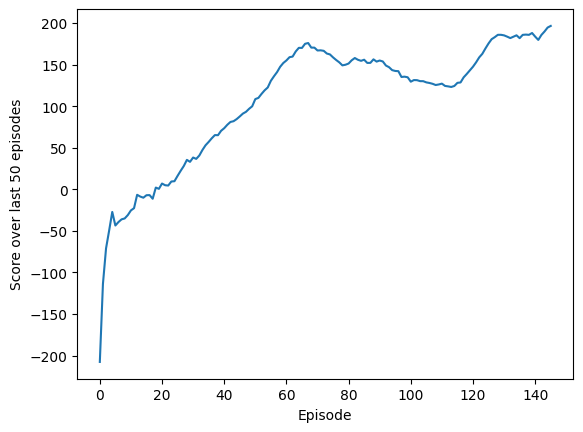

In [18]:
history = pd.DataFrame(
    history, columns=['Episode', 'Score'])

(fig, ax) = plt.subplots(1, 1)

ax.plot(history['Episode'], history['Score'])

ax.set_xlabel('Episode')
ax.set_ylabel('Score over last 50 episodes')

plt.show()

# DDPG

In [6]:
GAMMA = 0.99
BATCH_SIZE = 64
BUFFER_SIZE = 10000
MIN_REPLAY_SIZE = 5000
TAU = 0.01

In [7]:
# Random noise generator: Taken from OpenAI baselines
class ActionNoise(object):
    def reset(self):
        pass

class OrnsteinUhlenbeckActionNoise(ActionNoise):
    def __init__(self, mu, sigma, theta=.15, dt=1e-2, x0=None):
        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.dt = dt
        self.x0 = x0
        self.reset()

    def __call__(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        self.x_prev = x
        return x

    def reset(self):
        self.x_prev = self.x0 if self.x0 is not None else np.zeros_like(self.mu)

    def __repr__(self):
        return 'OrnsteinUhlenbeckActionNoise(mu={}, sigma={})'.format(self.mu, self.sigma)

# Policy/Actor Network
class PolicyNet(nn.Module):

    def __init__(self, input_size, hidden_units, output_size, pmin, pmax):
        super(PolicyNet, self).__init__()
        self.pmin = pmin
        self.pmax = pmax
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_units, device=device),
            nn.ReLU(),
            nn.Linear(hidden_units, int(hidden_units/2), device=device),
            nn.ReLU(),
            nn.Linear(int(hidden_units/2), output_size, device=device),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.model(x) * self.pmax
        torch.clip_(x, self.pmin, self.pmax)
        return x

    def __call__(self, x):
        out = self.forward(x)
        return out

#Critic Network
class DQN(nn.Module):

    def __init__(self, input_size, hidden_units):
        super(DQN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_units, device=device),
            nn.ReLU(),
            nn.Linear(hidden_units, int(hidden_units/2), device=device),
            nn.ReLU(),
            nn.Linear(int(hidden_units/2), 1, device=device)
        )

    def forward(self, state, action):
        x = torch.cat([state, action], 1)
        x = self.model(x)
        return x

    def __call__(self, state, action):
        out = self.forward(state, action)
        return out
    
Transition = namedtuple('Transition', ('states', 'actions', 'rewards', 'dones', 'next_states'))
class Replay_memory():

    def __init__(self, env, fullsize, minsize, batchsize):
        self.env = env
        self.memory = deque(maxlen=fullsize)
        self.rewards = deque(maxlen=50)
        self.batchsize = batchsize
        self.minsize = minsize

    def append(self, transition):
        self.memory.append(transition)
    
    def sample_batch(self):
        batch = random.sample(self.memory, self.batchsize)
        batch = Transition(*zip(*batch))
        states = torch.from_numpy(np.array(batch.states, dtype=np.float32)).to(device)
        actions = torch.from_numpy(np.array(batch.actions, dtype=np.float32)).to(device)
        rewards = torch.from_numpy(np.array(batch.rewards, dtype=np.float32)).unsqueeze(1).to(device)
        dones = torch.from_numpy(np.array(batch.dones, dtype=np.bool8)).unsqueeze(1).to(device)
        next_states = torch.from_numpy(np.array(batch.next_states, dtype=np.float32)).to(device)
        return states, actions, rewards, dones, next_states

    def initialize(self):
        obs = env.reset()
        for _ in range(self.minsize):
            action = self.env.action_space.sample()
            new_obs, reward, done, info = env.step(action)
            transition = Transition(obs, action, reward, done, new_obs)
            self.append(transition)
            obs = new_obs
            if done:
                self.env.reset()
        return self
    
T = lambda x: torch.as_tensor(x, dtype=torch.float32, device=device)
Ti = lambda x: torch.as_tensor(x, dtype=torch.int64, device=device)

In [8]:
std_dev = 0.2
ou_noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(1), sigma=float(std_dev) * np.ones(1))

env = gym.make(env_name := 'LunarLanderContinuous-v2')
obs = env.reset()
episode_reward = 0.0

obs_size = env.observation_space.shape[0]
act_size = env.action_space.shape[0]
hiddenlayers = 128
output_minrange = env.action_space.low
output_maxrange = env.action_space.high

replay_memory = Replay_memory(env, BUFFER_SIZE,
                              MIN_REPLAY_SIZE, BATCH_SIZE).initialize()

actor = PolicyNet(obs_size, hiddenlayers, act_size, T(output_minrange), T(output_maxrange))
actor_target = copy.deepcopy(actor)
critic = DQN(obs_size + act_size, hiddenlayers)
critic_target = copy.deepcopy(critic)

actor_optimizer  = optim.AdamW(actor.parameters(), lr=0.0003)
critic_optimizer = optim.AdamW(critic.parameters(), lr=0.0003)

In [10]:
def update():
        states, actions, rewards, dones, next_states = replay_memory.sample_batch()
        
        ou_noise.reset()
        
        # Critic loss  
        Qvals = critic(states, actions)
        with torch.no_grad():
            actions_ = actor_target(next_states)
            Qvals_ = critic_target(next_states, actions_)
            Qvals_[dones] = 0.0
            target = rewards + GAMMA * Qvals_
        critic_loss = F.smooth_l1_loss(target, Qvals) 

        # Actor loss
        actor_loss = -critic(states, actor(states)).mean()
        
        # update networks
        actor_optimizer.zero_grad()
        actor_loss.backward()
        actor_optimizer.step()

        critic_optimizer.zero_grad()
        critic_loss.backward() 
        critic_optimizer.step()

        # update target networks 
        for target_param, param in zip(actor_target.parameters(), actor.parameters()):
            target_param.data.copy_(param.data * TAU + target_param.data * (1.0 - TAU))

        for target_param, param in zip(critic_target.parameters(), critic.parameters()):
            target_param.data.copy_(param.data * TAU + target_param.data * (1.0 - TAU))

## Training

In [11]:
returns = deque(maxlen=50)
history = []

for episode in count():
    state = env.reset()
    episode_reward = 0
    done = False
    while not done:
        with torch.no_grad():
            action = actor(T(state)).cpu().numpy() + ou_noise()
        new_state, reward, done, _ = env.step(action) 
        transition = Transition(state, action, reward, done, new_state)
        replay_memory.append(transition)
        update()         
        state = new_state
        episode_reward += reward
            
    returns.append(episode_reward)
    score = np.mean(returns)
    
    history.append((episode,score))
    print(f'Episode: {episode}  Return: {episode_reward}  Average Return: {score}      ', end='\r')
    
    if episode > 0 and episode % 100 == 0:
        print(f'Episode: {episode}  Return: {episode_reward}  Average Return: {score}')
    if score >= 195:
        print(f'Solved! Episode: {episode}  Return: {episode_reward}  Average Return: {score}')
        break

Episode: 100  Return: 140.47712409572557  Average Return: 21.967313543810018      
Episode: 200  Return: -161.34947192658092  Average Return: 3.7432489459286056       
Episode: 300  Return: 146.32209425246418  Average Return: 51.68344311162897         
Episode: 400  Return: 229.85712285522789  Average Return: 8.46210855097206         
Episode: 500  Return: 254.70504577423924  Average Return: 54.74644978323483         
Episode: 600  Return: 255.42798256245052  Average Return: 78.42130372867445        
Episode: 700  Return: 8.551664862686351  Average Return: 89.34278940345584         
Episode: 800  Return: -152.5613647352972  Average Return: 129.67565430835816       
Episode: 900  Return: -150.77302252147288  Average Return: -1.4801545684434092      
Episode: 1000  Return: -71.8971185510094  Average Return: 11.662680399546268         
Episode: 1100  Return: -126.01991703776436  Average Return: 36.37437671955667        
Solved! Episode: 1153  Return: 288.25481978119274  Average Return: 20

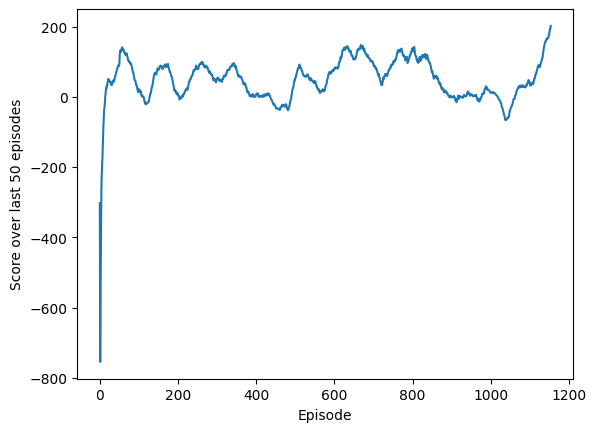

In [12]:
history = pd.DataFrame(
    history, columns=['Episode', 'Score'])

(fig, ax) = plt.subplots(1, 1)

ax.plot(history['Episode'], history['Score'])

ax.set_xlabel('Episode')
ax.set_ylabel('Score over last 50 episodes')

plt.show()